### Import Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

### Load Data

In [2]:
company = 'NTDOY' # replace with stock symbol/ticker symbol

start = dt.datetime(2011,1,1)
end = dt.datetime(2020,12,31)

data=pdr.DataReader(company, 'yahoo', start, end)
print(data.head())

                 High        Low       Open      Close   Volume  Adj Close
Date                                                                      
2010-12-31  36.540001  36.080002  36.250000  36.330002    34200  36.330002
2011-01-03  36.930000  36.450001  36.450001  36.700001    84600  36.700001
2011-01-04  35.750000  35.299999  35.299999  35.500000  1223900  35.500000
2011-01-05  34.650002  34.459999  34.549999  34.599998   835600  34.599998
2011-01-06  35.459999  35.099998  35.200001  35.250000   184700  35.250000


### Prepare Data

In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

pred_days = 30

x_train= []
y_train= []

for x in range(pred_days, len(scaled_data)):
    x_train.append(scaled_data[x-pred_days:x, 0])
    y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train= np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### LSTM Model

In [4]:
model = Sequential()
### LSTM Architecture
model.add(LSTM(units=40, return_sequences = True, activation='tanh', input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=40, activation='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=40, activation='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=40, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='rmsprop', loss = 'mean_squared_error', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=256, batch_size= 128)

Train on 2488 samples
Epoch 1/256
2488/2488 [==============================] - 7s 3ms/sample - loss: 0.0202 - accuracy: 8.0386e-04
Epoch 2/256
2488/2488 [==============================] - 1s 496us/sample - loss: 0.0067 - accuracy: 8.0386e-04
Epoch 3/256
2488/2488 [==============================] - 1s 439us/sample - loss: 0.0055 - accuracy: 8.0386e-04
Epoch 4/256
2488/2488 [==============================] - 1s 417us/sample - loss: 0.0058 - accuracy: 8.0386e-04
Epoch 5/256
2488/2488 [==============================] - 1s 421us/sample - loss: 0.0045 - accuracy: 8.0386e-04
Epoch 6/256
2488/2488 [==============================] - 1s 431us/sample - loss: 0.0046 - accuracy: 8.0386e-04
Epoch 7/256
2488/2488 [==============================] - 1s 446us/sample - loss: 0.0044 - accuracy: 8.0386e-04
Epoch 8/256
2488/2488 [==============================] - 1s 420us/sample - loss: 0.0046 - accuracy: 8.0386e-04
Epoch 9/256
2488/2488 [==============================] - 1s 410us/sample - loss: 0.0041 - ac

### Testing the model accuracy

In [5]:
# Load Test Data

testdata_start = dt.datetime(2021,1,1)
testdata_end = dt.datetime.now()

test_data = pdr.DataReader(company, 'yahoo', testdata_start, testdata_end)
act_prices = test_data['Close'].values

total_data = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_data[len(total_data) - len(test_data) - pred_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

### Predictions on the test data

In [6]:
x_test=[]

for x in range(pred_days, len(model_inputs)):
    x_test.append(model_inputs[x-pred_days:x ,0])
    
x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
    
pred_prices = model.predict(x_test)
pred_prices = scaler.inverse_transform(pred_prices)

### Plot predicted 

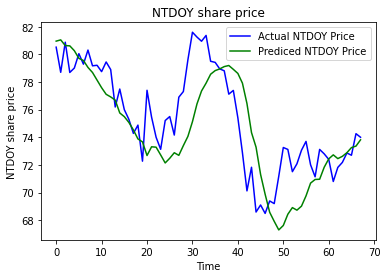

In [7]:
plt.plot(act_prices, color='blue', label=f"Actual {company} Price")
plt.plot(pred_prices, color = 'green', label = f"Prediced {company} Price")
plt.title(f"{company} share price")
plt.xlabel('Time')
plt.ylabel(f"{company} share price")
plt.legend()
plt.show()

### Predict one day later

In [8]:
next_day = [model_inputs[len(model_inputs) - pred_days:len(model_inputs + 1 ), 0]]
next_day = np.array(next_day)
next_day = np.reshape(next_day, (next_day.shape[0], next_day.shape[1],1))

next_day_pred = model.predict(next_day)
next_day_pred = scaler.inverse_transform(next_day_pred)
print(f"Prediction: {next_day_pred}")

Prediction: [[73.94994]]
